# Hot jupiter phase curve example

In [1]:
%matplotlib inline

In [ ]:
%run notebook_setup.py

In this notebook, we'll run through a brief example of how to model a full hot jupiter light curve -- including the transit, secondary eclipse, and phase curve -- using the machinery of the `exoplanet` package.

Let's begin with our custom imports. Note that we want to run `starry` in `lazy` mode (the default), since we need to be able to compute analytic derivatives of the model for use in `pymc3`.

In [2]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import exoplanet

starry.config.quiet = True
np.random.seed(1)

## Generating a dataset

Let's generate some synthetic data. First we create a star...

In [3]:
A = starry.Primary(starry.Map(ydeg=0, udeg=2, amp=1.0), m=1.0, r=1.0, prot=1.0)
A.map[1] = 0.4
A.map[2] = 0.2

... and now we instantiate the planet...

In [4]:
# These are the parameters we're going to try to infer
log_amp_true = -3.0
offset_true = 30.0

b = starry.Secondary(
    starry.Map(ydeg=1, udeg=0, amp=10 ** log_amp_true, inc=90.0, obl=0.0),
    m=0.0,
    r=0.1,
    inc=90.0,
    prot=1.0,
    porb=1.0,
)
b.map[1, 0] = 0.5
b.theta0 = 180.0 + offset_true

Most of the parameters should be self-explanatory (check the docs for details). For the planet, we give it a simple dipole map by setting only the $Y_{1,0}$ coefficient. We then set the `theta0` parameter to be $180^\circ$ plus an offset, which we set to be $30^\circ$. The parameter `theta0` is the rotational phase of the map at the reference time `t0`, which in this case is the time of transit. For a tidally-locked close-in planet, we usually want the bright side of the map to be facing the star at that point, which we accomplish by setting `theta0=180`. The offset captures the misalignment between the hot spot of the planet and the sub-stellar point, as is seen in the hot jupiter [HD 189733b](https://ui.adsabs.harvard.edu/abs/2012ApJ...747L..20M/abstract). In this notebook, we'll attempt to solve for this value.

Next, we instantiate the system:

In [5]:
sys = starry.System(A, b)

We can now generate a synthetic light curve, and add some noise:

INFO (theano.gof.compilelock): Waiting for existing lock by process '59682' (I am process '63255')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/schlecker/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir
/Users/schlecker/.conda/envs/PyCharmStandardVenv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/schlecker/.conda/envs/PyCharmStandardVenv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq

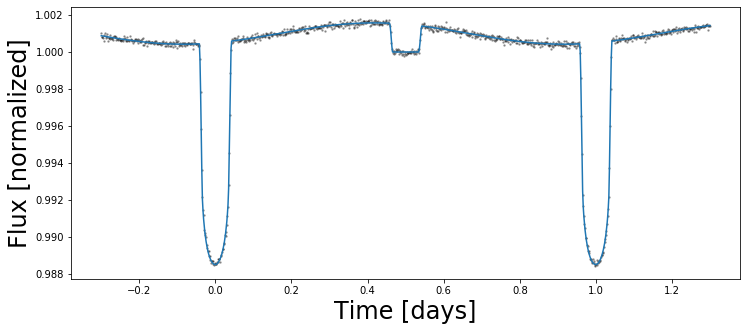

In [7]:
t = np.linspace(-0.3, 1.3, 1000)
flux_true = sys.flux(t).eval()
ferr = 1e-4
flux = flux_true + ferr * np.random.randn(len(t))
plt.figure(figsize=(12, 5))
plt.plot(t, flux, "k.", alpha=0.3, ms=3)
plt.plot(t, flux_true)
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

By eye we can tell there's an offset, since the peak in the phase curve does not coincide with the secondary eclipse.

## Fitting the data

We're going to fit this light curve using `exoplanet` and `pymc3`. Let's begin fresh and define a new star, planet, and system, this time *within a pymc3 model context*:

In [15]:
with pm.Model() as model:

    # These are the variables we're solving for;
    # here we're placing wide Gaussian priors on them.
    offset = pm.Normal("offset", 0.0, 50.0, testval=0.11)
    log_amp = pm.Normal("log_amp", -4.0, 2.0, testval=-3.91)

    # Instantiate the star; all its parameters are assumed
    # to be known exactly
    A = starry.Primary(
        starry.Map(ydeg=0, udeg=2, amp=1.0, inc=90.0, obl=0.0), m=1.0, r=1.0, prot=1.0
    )
    A.map[1] = 0.4
    A.map[2] = 0.2

    # Instantiate the planet. Everything is fixed except for
    # its luminosity and the hot spot offset.
    b = starry.Secondary(
        starry.Map(ydeg=1, udeg=0, amp=10 ** log_amp, inc=90.0, obl=0.0),
        m=0.0,
        r=0.1,
        prot=1.0,
        porb=1.0,
    )
    b.map[1, 0] = 0.5
    b.theta0 = 180.0 + offset

    # Instantiate the system as before
    sys = starry.System(A, b)

    # Our model for the flux
    flux_model = pm.Deterministic("flux_model", sys.flux(t))

    # This is how we tell `pymc3` about our observations;
    # we are assuming they are ampally distributed about
    # the true model. This line effectively defines our
    # likelihood function.
    pm.Normal("obs", flux_model, sd=ferr, observed=flux)

/Users/schlecker/.conda/envs/PyCharmStandardVenv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Great! The first thing we usually do is run this model through an optimizer (which is usually fast, since `starry` computes derivatives):

In [9]:
%%time
with model:
    map_soln = exoplanet.optimize()

/Users/schlecker/.conda/envs/PyCharmStandardVenv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/schlecker/.conda/envs/PyCharmStandardVenv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [log_amp, offset]
0it [00:00, ?it/s]/Users/schlecker/.conda/envs/PyCharmStandardVenv/lib/python3.7/site-packages/theano

CPU times: user 3.36 s, sys: 177 ms, total: 3.54 s
Wall time: 3.51 s



message: Optimization terminated successfully.
logp: -26221.39778642102 -> 7803.390365698368


Here's what our best model looks like:

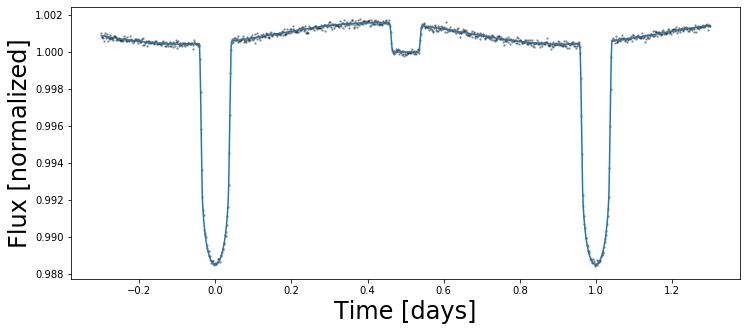

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(t, flux, "k.", alpha=0.3, ms=3)
plt.plot(t, map_soln["flux_model"])
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

And here are the best-fit values of the two parameters:

In [11]:
print("offset:", map_soln["offset"])
print("log_amp:", map_soln["log_amp"])

offset: 30.052031509249538
log_amp: -2.998333491706592


Not bad! If we just cared about finding the best solution, we'd be done, but we actually want posteriors over the model parameters. For this, we're going to do sampling with `pymc3`:

In [12]:
%%time
with model:
    trace = pm.sample(
        tune=250,
        draws=500,
        start=map_soln,
        chains=4,
        cores=1,
        step=exoplanet.get_dense_nuts_step(target_accept=0.9),
    )

/Users/schlecker/.conda/envs/PyCharmStandardVenv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/schlecker/.conda/envs/PyCharmStandardVenv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sequential sampling (4 chains in 1 job)
NUTS: [log_amp, offset]
Sampling chain 3, 0 divergences: 100%|██████████| 750/750 [00:03<00:00, 198.94it/s]
/U

CPU times: user 1min 22s, sys: 974 ms, total: 1min 23s
Wall time: 31.9 s


And we're done! It's usually a good idea to look at a summary of the sampling procedure:

In [13]:
pm.summary(trace, var_names=["log_amp", "offset"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
log_amp,-2.998,0.002,-3.001,-2.995,0.000,0.000,1074.0,1073.0,1104.0,1048.0,1.01
offset,30.065,0.457,29.232,30.888,0.011,0.008,1731.0,1729.0,1705.0,1259.0,1.00


The `mc_errors` are relatively small, the `Rhat` convergence criterion is close to 1, and the number of effective samples `n_eff` is over 1000, all of which are good. We should probably run the sampler a bit longer, but this should be good enough for demonstration purposes. Let's plot our posterior distributions:

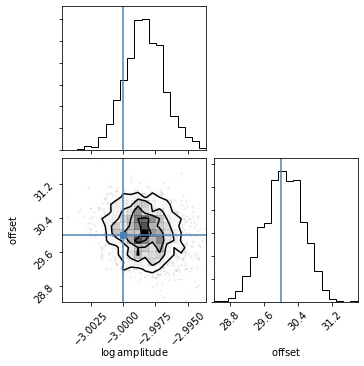

In [14]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["log_amp", "offset"])
corner.corner(
    np.array(samples),
    truths=[log_amp_true, offset_true],
    labels=[r"$\log\,\mathrm{amplitude}$", r"$\mathrm{offset}$"],
);

Looks great! The blue lines indicate the true values.